####  **Import Required Libraries**

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

In [17]:
# Load model and preprocessing objects
poly_lr = joblib.load("../resources/models/poly_lr_model.pkl")
scaler = joblib.load("../resources/models/scaler.pkl")
encoder = joblib.load("../resources/models/encoder.pkl")
poly = joblib.load("../resources/models/poly_features.pkl")


#### **Model Interpretability**

In [18]:
numeric_features = [
    "call_failure",
    "complains",
    "seconds_of_use",
    "frequency_of_SMS",
    "distinct_called_numbers",
    "charge_amount",
    "status_active"
]
categorical_features = [ "tariff_plan", "age_group"]

##### Get Feature Names After Polynomial Expansion

In [19]:
# Get original feature names
cat_feature_names = encoder.get_feature_names_out(categorical_features)
all_base_features = numeric_features + list(cat_feature_names)

# Expand polynomial features
poly_feature_names = poly.get_feature_names_out(all_base_features)

##### Extract Coefficients from Model

In [20]:
# Coefficients and intercept
coefficients = poly_lr.coef_     
intercept = poly_lr.intercept_

##### Combine Into a Readable Equation Format

In [7]:
# Combine names and coefficients with formatting improvements
terms = [
    f"{coef:.3f} * {name.replace('^2', '²')}"  # Round to 3 decimals and format exponents
    for coef, name in zip(coefficients, poly_feature_names)
]

# Build equation with line breaks every few terms
equation = f"y = {intercept:.3f}"
for i, term in enumerate(terms):
    prefix = "\n+ " if i % 3 == 0 else " + "  # Line break every 3 terms
    equation += prefix + term

print(equation)

y = 6.770
+ -0.011 * call_failure + -0.018 * complains + 1.275 * seconds_of_use
+ 2.286 * frequency_of_SMS + 0.012 * distinct_called_numbers + -0.134 * charge_amount
+ -0.206 * status_active + -0.169 * tariff_plan_2 + -0.191 * age_group_2
+ -0.239 * age_group_3 + -0.484 * age_group_4 + -0.710 * age_group_5
+ 0.004 * call_failure² + -0.005 * call_failure complains + -0.003 * call_failure seconds_of_use
+ -0.073 * call_failure frequency_of_SMS + -0.043 * call_failure distinct_called_numbers + 0.026 * call_failure charge_amount
+ 0.022 * call_failure status_active + -0.058 * call_failure tariff_plan_2 + 0.075 * call_failure age_group_2
+ 0.047 * call_failure age_group_3 + 0.004 * call_failure age_group_4 + -0.095 * call_failure age_group_5
+ -0.057 * complains² + 0.007 * complains seconds_of_use + -0.034 * complains frequency_of_SMS
+ -0.030 * complains distinct_called_numbers + 0.046 * complains charge_amount + -0.021 * complains status_active
+ 0.063 * complains tariff_plan_2 + 0.189 * 

#### Top Features

In [8]:
# Sort features by absolute coefficient value and get top 10
top_features = sorted(zip(coefficients, poly_feature_names),
                     key=lambda x: abs(x[0]),
                     reverse=True)[:10]

# Create DataFrame for better visualization
results_df = pd.DataFrame({
    'Feature': [name for _, name in top_features],
    'Coefficient': [coef for coef, _ in top_features]
})

# Display results with formatted output
print("\nTop 10 Features by Coefficient Magnitude:")
print("-" * 50)
print(results_df.to_string(index=False, float_format=lambda x: f"{x:>10.4f}"))


Top 10 Features by Coefficient Magnitude:
--------------------------------------------------
                       Feature  Coefficient
              frequency_of_SMS       2.2861
                seconds_of_use       1.2746
frequency_of_SMS status_active      -1.1591
                 age_group_5^2      -0.7096
                   age_group_5      -0.7096
  frequency_of_SMS age_group_3      -0.6631
  frequency_of_SMS age_group_4      -0.6625
  frequency_of_SMS age_group_2      -0.6479
     tariff_plan_2 age_group_2       0.5378
    seconds_of_use age_group_3      -0.4903


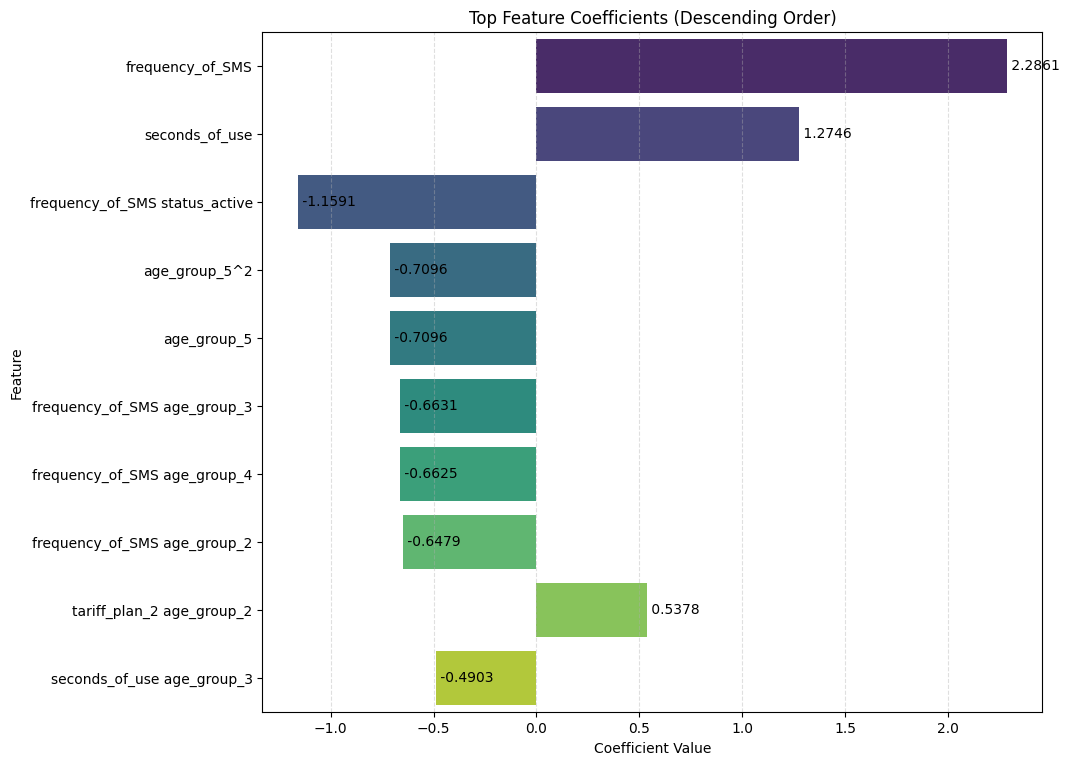

In [9]:
# Create DataFrame from top features
df = pd.DataFrame(top_features, columns=["Coefficient", "Feature"])

# Sort in descending order of absolute value
df = df.reindex(df["Coefficient"].abs().sort_values(ascending=False).index)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=df, x="Coefficient", y="Feature", hue="Feature", legend=False, palette="viridis")

# Add labels
for i, v in enumerate(df["Coefficient"]):
    plt.text(v, i, f' {v:.4f}', va='center')

plt.title("Top Feature Coefficients (Descending Order)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.subplots_adjust(left=0.3, right=0.95, top=0.95, bottom=0.1)
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.show()


In [10]:
# Create DataFrame from all coefficients
coef_df = pd.DataFrame({
    'Feature': poly_feature_names,
    'Coefficient': poly_lr.coef_
})

# Sort by absolute value (ascending)
coef_df['abs_coef'] = coef_df['Coefficient'].abs()
bottom_10 = coef_df.sort_values(by='abs_coef').head(10)

# Display results
print("\nBottom 10 Features by Coefficient Magnitude:")
print("-" * 50)
print(bottom_10[['Feature', 'Coefficient']].to_string(index=False, float_format=lambda x: f"{x:>10.4f}"))


Bottom 10 Features by Coefficient Magnitude:
--------------------------------------------------
                    Feature  Coefficient
    age_group_2 age_group_3       0.0000
    age_group_3 age_group_5       0.0000
    age_group_3 age_group_4       0.0000
    age_group_2 age_group_4       0.0000
    age_group_4 age_group_5       0.0000
    age_group_2 age_group_5       0.0000
call_failure seconds_of_use      -0.0031
  distinct_called_numbers^2      -0.0036
             call_failure^2       0.0043
   call_failure age_group_4       0.0043


#### **Actual vs. Predicted CLV**

In [11]:
file_path = "../resources/data/output/customer_churn_with_predicted_clv.csv"   
df = pd.read_csv(file_path)

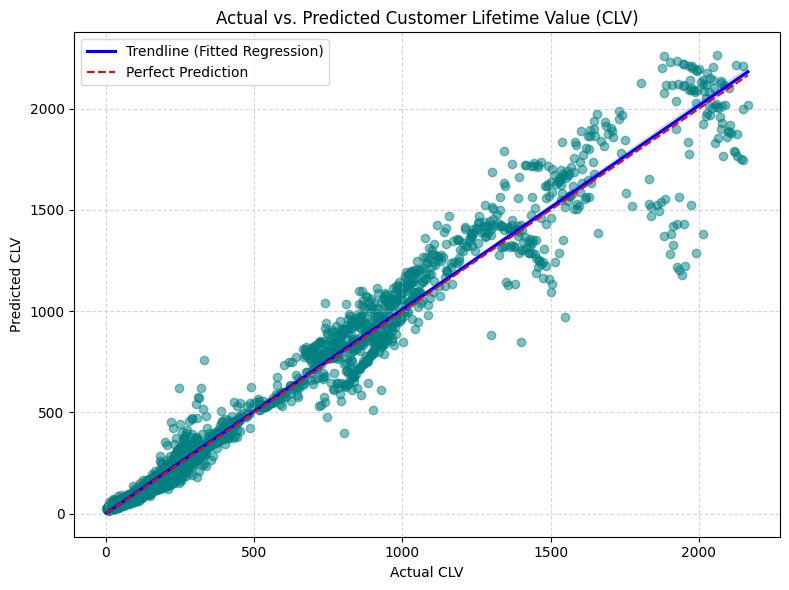

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot with trendline using sns.regplot
plt.figure(figsize=(8, 6))

# Regression plot (includes scatter + trendline)
sns.regplot(
    x="customer_value",
    y="predicted_clv",
    data=df,
    scatter_kws={'alpha': 0.5, 'color': 'teal'},
    line_kws={'color': 'blue', 'label': 'Trendline (Fitted Regression)'}
)

# Add perfect prediction line
plt.plot(
    [df["customer_value"].min(), df["customer_value"].max()],
    [df["customer_value"].min(), df["customer_value"].max()],
    color="red", linestyle="--", linewidth=1.5, label="Perfect Prediction"
)

plt.title("Actual vs. Predicted Customer Lifetime Value (CLV)")
plt.xlabel("Actual CLV")
plt.ylabel("Predicted CLV")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


The plot compares actual Customer Lifetime Value (CLV) against model predictions across the entire dataset.

- The red dashed line represents perfect prediction (y = x), where predicted CLV exactly matches actual CLV.

- The blue trendline is a regression line fitted through the predicted points. Its close alignment with the red line indicates that the model is highly accurate and unbiased across the full range of customer values.

- Minor spread is visible at higher CLV levels, but overall, the predictions track very well with actual values.